In [95]:

import numpy as np
import pyscf
from pyscf.hessian import thermo
from gpu4pyscf.dft import rks
from pyscf import gto

atom = '''
O     0.000000000     0.000000000     2.500000000
H    -0.663641000    -0.383071000     3.095377000
H     0.663588000     0.383072000     3.095377000
O     1.000000000     0.000000000     2.500000000
H    -1.663641000    -0.383071000     3.095377000
H     1.663588000     0.383072000     3.095377000
'''

mol = pyscf.M(
    atom=atom,                         # water molecule
    basis='def2-tzvpp',                # basis set
    output='./pyscf.log',              # save log file
    verbose=6                          # control the level of print info
    )

mf_GPU = rks.RKS(                      # restricted Kohn-Sham DFT
    mol,                               # pyscf.gto.object
    xc='b3lyp'                         # xc funtionals, such as pbe0, wb97m-v, tpss,
    ).density_fit()                    # density fitting

mf_GPU.grids.atom_grid = (99,590)      # (99,590) lebedev grids, (75,302) is often enough
mf_GPU.conv_tol = 1e-10                # controls SCF convergence tolerance
mf_GPU.max_cycle = 50                  # controls max iterations of SCF
mf_GPU.conv_tol_cpscf = 1e-3           # controls max iterations of CPSCF (for hessian)

# Compute Energy
e_dft = mf_GPU.kernel()
print(f"total energy = {e_dft}")       # -76.46668196729536

# Compute Gradient
g = mf_GPU.nuc_grad_method()
g_dft = g.kernel()

# Compute Hessian
h = mf_GPU.Hessian()
h.auxbasis_response = 2                # 0: no aux contribution, 1: some contributions, 2: all
mf_GPU.cphf_grids.atom_grid = (50,194) # customize grids for solving CPSCF equation, SG1 by default
h_dft = h.kernel()

# harmonic analysis
results = thermo.harmonic_analysis(mol, h_dft)
thermo.dump_normal_mode(mol, results)

results = thermo.thermo(
    mf_GPU,                            # GPU4PySCF object
    results['freq_au'],
    298.15,                            # room temperature
    101325)                            # standard atmosphere

thermo.dump_thermo(mol, results)

# force translational symmetry
natm = mol.natm
h_dft = h_dft.transpose([0,2,1,3]).reshape(3*natm,3*natm)
h_diag = h_dft.sum(axis=0)
h_dft -= np.diag(h_diag)

overwrite output file: ./pyscf.log
total energy = -152.00036907999544


In [501]:
import sys

sys.path.append("/pchem-data/meuwly/boittier/home/pyscfgpu/tests/supermolecule")
from supermol import compute_interaction_energy

sys.path.append("/pchem-data/meuwly/boittier/home/pyscfgpu/helper_functions/")
from basis import *

monomer_a = '''
O 0.000000 0.000000  0.000000
H 0.758602 0.000000  0.504284
H 0.260455 0.000000 -0.872893
'''

monomer_b = '''
O 3.000000 0.500000  0.000000
H 3.758602 0.500000  0.504284
H 3.260455 0.500000 -0.872893
'''

ATOM      1  C   LIG     1       3.573  -5.315  13.191  1.00  0.00      LIG 
ATOM      2  H1  LIG     1       4.145  -5.803  12.351  1.00  0.00      LIG 
ATOM      3  H2  LIG     1       2.697  -5.727  13.717  1.00  0.00      LIG 
ATOM      4  CL1 LIG     1       2.966  -5.158  11.562  1.00  0.00      LIG 
ATOM      5  CL2 LIG     1       3.446  -5.061  11.466  1.00  0.00      LIG 
ATOM      6  C   LIG     2      -7.178  -5.367 -13.619  1.00  0.00      LIG 
ATOM      7  H1  LIG     2      -8.297  -5.255 -13.418  1.00  0.00      LIG 
ATOM      8  H2  LIG     2      -6.677  -5.803 -14.546  1.00  0.00      LIG 
ATOM      9  CL1 LIG     2      -7.914  -6.301 -14.928  1.00  0.00      LIG 
ATOM     10  CL2 LIG     2      -8.402  -6.017 -14.725  1.00  0.00      LIG 

In [119]:
cc.Cartesian?

Init signature:
cc.Cartesian(
    frame=None,
    atoms=None,
    coords=None,
    index=None,
    metadata=None,
    _metadata=None,
)
Docstring:     
The main class for dealing with cartesian Coordinates.

**Mathematical Operations**:

It supports binary operators in the logic of the scipy stack, but you need
python3.x for using the matrix multiplication operator ``@``.

The general rule is that mathematical operations using the binary operators
``+ - * / @`` and the unary operators ``+ - abs``
are only applied to the ``['x', 'y', 'z']`` columns.

**Addition/Subtraction/Multiplication/Division**:
If you add a scalar to a Cartesian it is added elementwise onto the
``['x', 'y', 'z']`` columns.
If you add a 3-dimensional vector, list, tuple... the first element of this
vector is added elementwise to the ``'x'`` column of the
Cartesian instance and so on.
The last possibility is to add a matrix with
``shape=(len(Cartesian), 3)`` which is again added elementwise.
The same rules are true f

In [123]:
import chemcoord as cc
import time

water = cc.Cartesian.read_xyz("../ghost-atoms/opt.xyz").get_zmat()

In [124]:
import ase
from ase.io import read
from ase.visualize import view

mini = ase.io.read("/pchem-data/meuwly/boittier/home/project-mmml/eric-copy/mini.pdb")

view(mini[:10], viewer="x3d")

In [127]:
dcm = cc.Cartesian(    
    frame=None,
    atoms=mini[:10].symbols,
    coords=mini[:10].positions).get_zmat()

In [159]:
import sympy
sympy.init_printing()
d1 = sympy.Symbol('d1')
d2 = sympy.Symbol('d2')
b1 = sympy.Symbol('b1')
symb_d = dcm.copy()
symb_d.safe_loc[5, 'dihedral'] = d1
symb_d.safe_loc[8, 'dihedral'] = d2
symb_d.safe_loc[6, 'bond'] = b1

In [160]:
symb_d

,atom,b,bond,a,angle,d,dihedral
0,C,origin,19.015075,e_z,21.433801,e_x,-81.942197
1,H,0,1.11108,e_z,151.740231,e_x,175.732522
2,H,0,1.110882,1,88.965046,e_x,-56.008137
3,Cl,0,1.787,1,125.400317,2,141.977645
4,Cl,0,1.787754,1,111.125123,2,-108.698421
6,H,3,$b_{1}$,0,133.515387,1,165.534685
5,C,6,1.110932,3,157.638696,0,$d_{1}$
8,Cl,5,1.786675,6,134.215947,3,$d_{2}$
9,Cl,5,1.787203,6,114.849876,8,134.990812
7,H,5,1.110604,6,51.675701,8,-143.505985


In [161]:
test_dub_ase.positions

array([[  0.974     ,  -6.88      ,  17.7       ],
       [  0.521     ,  -7.131     ,  18.683     ],
       [  0.663     ,  -5.824     ,  17.849     ],
       [  0.927     ,  -7.915     ,  16.244     ],
       [  2.759     ,  -6.94      ,  17.779     ],
       [ 16.599     ,  -7.732     , -10.826     ],
       [ 17.28134028,  -7.35097788, -11.61555867],
       [ 18.09763456,  -5.78909606, -11.90949378],
       [ 16.79303289,  -7.75129894, -13.28750153],
       [ 17.23883573,  -8.36947984, -11.17477741]])

In [162]:
test_dub

,atom,x,y,z
0,C,0.974000,-6.880000,17.700000
1,H,0.521000,-7.131000,18.683000
2,H,0.663000,-5.824000,17.849000
3,Cl,0.927000,-7.915000,16.244000
4,Cl,2.759000,-6.940000,17.779000
6,H,16.599000,-7.732000,-10.826000
5,C,17.281340,-7.350978,-11.615559
8,Cl,18.097635,-5.789096,-11.909494
9,Cl,16.793033,-7.751299,-13.287502
7,H,17.238836,-8.369480,-11.174777


In [164]:
def format_atoms(a, b, c):
    test_dub = symb_d.subs(b1, a)
    test_dub = test_dub.subs(d1, b)
    test_dub = test_dub.subs(d2, c)
    test_dub = test_dub.get_cartesian()
    test_dub_ase = ase.Atoms(test_dub["atom"], test_dub[["x", "y", "z"]])
    return test_dub_ase

scan_atoms = []

for i in [0, 45, 90, 135]:
    for j in [0, 45, 90, 135]:
        for k in [3, 4, 5]:
            scan_atoms.append(format_atoms(k, i, j))
        


In [165]:
view(scan_atoms[0], viewer="x3d")

In [166]:
view(scan_atoms[-1], viewer="x3d")

In [134]:
# view(ase.io.read("dcm.xyz"), viewer="x3d")

In [81]:
import sympy
sympy.init_printing()
d = sympy.Symbol('d')

In [72]:
symb_water = water.copy()
symb_water.safe_loc[4, 'dihedral'] = d

In [73]:
symb_water

,atom,b,bond,a,angle,d,dihedral
0,O,origin,0.478270,e_z,103.532203,e_x,-40.82705
1,H,0,1.830428,e_z,43.915196,e_x,98.049424
2,H,0,1.844838,1,102.319834,e_x,7.907999
3,O,2,3.598165,0,175.906488,1,-159.975298
4,H,3,1.833121,2,100.373689,1,$d$
5,H,3,1.832171,2,101.936899,4,-106.257108


In [74]:
symb_water.subs(d, 2)

,atom,b,bond,a,angle,d,dihedral
0,O,origin,0.478270,e_z,103.532203,e_x,-40.827050
1,H,0,1.830428,e_z,43.915196,e_x,98.049424
2,H,0,1.844838,1,102.319834,e_x,7.907999
3,O,2,3.598165,0,175.906488,1,-159.975298
4,H,3,1.833121,2,100.373689,1,2.000000
5,H,3,1.832171,2,101.936899,4,-106.257108


In [75]:
test_dub = symb_water.subs(d, 1).get_cartesian()
test_dub

,atom,x,y,z
0,O,0.351854,-0.304002,-0.111911
1,H,-0.629090,1.047578,0.637387
2,H,2.052063,0.411552,-0.138379
3,O,5.458734,1.567498,-0.210253
4,H,5.262850,3.220058,0.558516
5,H,6.226221,0.567934,1.119667


In [88]:
test_dub_ase = ase.Atoms(test_dub["atom"], test_dub[["x", "y", "z"]])
view(test_dub_ase, viewer="x3d")

In [204]:
import pandas as pd


def process_data(intE_final_results):
    intE_results = pd.DataFrame([intE_final_results["intE_results"]])

    standard_res = {k:v for k,v in intE_final_results.items() if k != "intE_results"}
    standard_res.pop("results_A_ghost")
    standard_res.pop("results_B_ghost")

    standard_res_scaler = { k:  { kk: vv for kk,vv in v.items() if kk in scaler_cols} for k,v in standard_res.items()}

    def scalar_cols(key, v, n=6):
        axs = ["x", "y", "z"]
        return {key + f"_{i}_{axs[j]}": v[i][j] if i < v.shape[0] else 0 for i in range(n) for j in range(3)}
    
    def scalar_cols_hess(key, v, n=6):
        axs = ["x", "y", "z"]
        return {key + f"_{i}_{j}": v[i][j] if (i < v.shape[0] and j < v.shape[1]) else 0 for i in range(n*3) for j in range(n*3)}
    
    
    standard_res_gradient = { k:  [scalar_cols(kk, vv, n_atoms) for kk, vv in v.items() if kk == "gradient"] for k,v in standard_res.items()}
    gradients = {k: pd.DataFrame(standard_res_gradient[k]).to_numpy().reshape(n_atoms, 3) for k in standard_res_vector.keys()}
    
    standard_res_hessian = { k:  [scalar_cols_hess(kk, vv, n_atoms) for kk, vv in v.items() if kk == "hessian"] for k,v in standard_res.items()}
    hessian = {k: pd.DataFrame(standard_res_hessian[k]).to_numpy().reshape(n_atoms, 3, n_atoms, 3) for k in standard_res_vector.keys()}
    
    thermo_results = []
    keys = list(standard_res.keys())
    for key in keys:
        old  = standard_res[key]["thermo"]
        new = {}
        for k, v in old.items():
            if type(v) is tuple:
                if k != "rot_const":
                    value, unit = tuple(v)
                    if unit == "":
                        unit = "unitless"
                    new[k+"_"+unit] = value
                else:
                    value, unit = tuple(v)
                    new[k+"_x_"+unit] = value[0]
                    new[k+"_y_"+unit] = value[0]
                    new[k+"_z_"+unit] = value[0]
        thermo_results.append(new)
    
    thermo_results_df = pd.DataFrame(thermo_results, index=keys)

    output =     {    "thermo_results_df": thermo_results_df,
        "intE_results": intE_results, 
        "gradients": gradients, 
        "hessians": hessian, 
        "results": standard_res,
        }
    
    import numpy as np
    assert np.all(output["thermo_results_df"].index == ['results_AB', 'results_A', 'results_B'])
    formation_thermo = pd.DataFrame(output["thermo_results_df"].iloc[0] - output["thermo_results_df"].iloc[1] - output["thermo_results_df"].iloc[2])
    delta_thermo = pd.DataFrame(output["thermo_results_df"].iloc[1] - output["thermo_results_df"].iloc[2])
    mean_thermo = pd.DataFrame( (output["thermo_results_df"].iloc[1] - output["thermo_results_df"].iloc[2])/2)
    delta_keys = pd.DataFrame(delta_thermo)
    
    final_output = {
        "formation_thermo": formation_thermo,
        "delta_thermo": delta_thermo ,
        "mean_thermo": mean_thermo ,
        "delta_keys": delta_keys,
    }
    final_output.update(output)
    return final_output


In [417]:

test_basis_theory.keys()

dict_keys([('PBE1PBE', 'cc-pVDZ'), ('PBE1PBE', 'cc-pVTZ'), ('PBE1PBE', 'cc-pVQZ'), ('PBE1PBE', 'aug-cc-pVDZ'), ('PBE1PBE', 'aug-cc-pVTZ'), ('PBE1PBE', 'aug-cc-pVQZ'), ('PBE0', 'cc-pVDZ'), ('PBE0', 'cc-pVTZ'), ('PBE0', 'cc-pVQZ'), ('PBE0', 'aug-cc-pVDZ'), ('PBE0', 'aug-cc-pVTZ'), ('PBE0', 'aug-cc-pVQZ'), ('B3LYP', 'cc-pVDZ'), ('B3LYP', 'cc-pVTZ'), ('B3LYP', 'cc-pVQZ'), ('B3LYP', 'aug-cc-pVDZ'), ('B3LYP', 'aug-cc-pVTZ'), ('B3LYP', 'aug-cc-pVQZ'), ('PBE1PBE', '6-311++G**'), ('PBE1PBE', '6-311++G(3df,3pd)'), ('PBE0', '6-311++G**'), ('PBE0', '6-311++G(3df,3pd)'), ('B3LYP', '6-311++G**'), ('B3LYP', '6-311++G(3df,3pd)'), ('PBE1PBE', '6-311++G(3df,3pd)aug-cc-pV5Z'), ('PBE0', '6-311++G(3df,3pd)aug-cc-pV5Z'), ('B3LYP', '6-311++G(3df,3pd)aug-cc-pV5Z'), ('M06', 'cc-pVDZ'), ('M06', 'cc-pVTZ'), ('M06', 'cc-pVQZ'), ('M06', 'aug-cc-pVDZ'), ('M06', 'aug-cc-pVTZ'), ('M06', 'aug-cc-pVQZ'), ('M06', '6-311++G**'), ('M06', '6-311++G(3df,3pd)aug-cc-pV5Z'), ('M06_2X', 'cc-pVDZ'), ('M06_2X', 'cc-pVTZ'), ('M06_

In [528]:
test_basis_theory = {}

basis_sets = [
    'cc-pVDZ', 'cc-pVTZ', 'cc-pVQZ', 
    'aug-cc-pVDZ', 'aug-cc-pVTZ', 'aug-cc-pVQZ', 
             ]

methods = [
    "PBE1PBE", "PBE0", "B3LYP", "M06", "M06_2X", "WB97X_V"
          ]

n_atoms = 6

for method in methods:
    for basis in basis_sets:
        print(method, basis)
        intE_final_results = compute_interaction_energy(monomer_a, monomer_b, basis=basis, xc=method)
        output = process_data(intE_final_results)
        test_basis_theory[(method, basis)] = output

PBE1PBE cc-pVDZ

WARN: len(magmom) != natm. Set magmom to zero


WARN: len(magmom) != natm. Set magmom to zero

converged SCF energy = -152.835191405827
total energy = -152.83519140582692
--------------- DFRKS gradients ---------------
         x                y                z
0 O     0.0818915701     0.0012300938    -0.0286029232
1 H    -0.0609785982    -0.0017148136    -0.0311883432
2 H    -0.0229838667    -0.0003257293     0.0606252312
3 O     0.0795703551     0.0009311325    -0.0285690525
4 H    -0.0564487230     0.0000423198    -0.0353969848
5 H    -0.0210507196    -0.0001629559     0.0631326797
----------------------------------------------
Mode                                 0                   1                   2
Irrep
Freq [cm^-1]                      113.2616           1376.9908           1388.1463
Reduced mass [au]                   5.8584              1.0889              1.0835
Force const [Dyne/A]                0.0443              1.2164              1.2301
Char tem


KeyboardInterrupt



In [529]:
basis_sets = [
    'cc-pVDZ', 'cc-pVTZ', 'cc-pVQZ', 
    'aug-cc-pVDZ', 'aug-cc-pVTZ', 'aug-cc-pVQZ', 
    "6-311++G**", "6-311++G(3df,3pd)"
             # 'aug-cc-pV5Z'
]

methods = [
    "PBE1PBE", "PBE0", "B3LYP",
    "M06", "M06_2X", "WB97X_V"
          ]

n_atoms = 6

for method in methods:
    for basis in basis_sets:
        if (method, basis) not in test_basis_theory.keys():
            print(method, basis)
            intE_final_results = compute_interaction_energy(monomer_a, monomer_b, basis=basis, xc=method)
            output = process_data(intE_final_results)
            test_basis_theory[(method, basis)] = output

PBE1PBE cc-pVDZ

WARN: len(magmom) != natm. Set magmom to zero


WARN: len(magmom) != natm. Set magmom to zero

converged SCF energy = -152.835191405827
total energy = -152.83519140582692
--------------- DFRKS gradients ---------------
         x                y                z
0 O     0.0818915701     0.0012300938    -0.0286029232
1 H    -0.0609785982    -0.0017148136    -0.0311883432
2 H    -0.0229838667    -0.0003257293     0.0606252312
3 O     0.0795703551     0.0009311325    -0.0285690525
4 H    -0.0564487230     0.0000423198    -0.0353969848
5 H    -0.0210507196    -0.0001629559     0.0631326797
----------------------------------------------
Mode                                 0                   1                   2
Irrep
Freq [cm^-1]                      113.2616           1376.9908           1388.1463
Reduced mass [au]                   5.8584              1.0889              1.0835
Force const [Dyne/A]                0.0443              1.2164              1.2301
Char tem

In [530]:
output["intE_results"]
-152.299994 -(-76.350152 + - 76.205254)

0.25541200000000686

In [531]:
test_basis_theory_keys = test_basis_theory.keys()
basis_sets_ = [_[1] for _ in test_basis_theory_keys]
methods_ = [_[0] for _ in test_basis_theory_keys]
nbas = [test_basis_theory[_]["results"]["results_AB"]["mol"].nbas for _ in test_basis_theory_keys]
nao = [test_basis_theory[_]["results"]["results_AB"]["mol"].nao for _ in test_basis_theory_keys]

In [532]:
(test_basis_theory[('PBE1PBE', 'cc-pVDZ')]["results"]["results_AB"])

{'mol': <pyscf.gto.mole.Mole at 0x14a4f8099a00>,
 'calcs': [<CALCS.ENERGY: 0>,
  <CALCS.GRADIENT: 1>,
  <CALCS.HESSIAN: 2>,
  <CALCS.HARMONIC: 3>,
  <CALCS.THERMO: 4>],
 'energy': -152.83519140582692,
 'gradient': array([[ 8.18915701e-02,  1.23009378e-03, -2.86029232e-02],
        [-6.09785982e-02, -1.71481363e-03, -3.11883432e-02],
        [-2.29838667e-02, -3.25729285e-04,  6.06252312e-02],
        [ 7.95703551e-02,  9.31132531e-04, -2.85690525e-02],
        [-5.64487230e-02,  4.23197890e-05, -3.53969848e-02],
        [-2.10507196e-02, -1.62955936e-04,  6.31326797e-02]]),
 'hessian': array([[ 6.08019305e-01,  1.07709933e-03,  1.34743259e-01,
         -5.29714984e-01, -2.15565876e-04, -3.04555471e-01,
         -7.38976656e-02, -2.99701783e-05,  1.70634537e-01,
         -3.67222235e-03, -7.38230107e-04, -1.80104272e-03,
         -9.38570289e-04, -3.02637402e-04,  1.18549521e-03,
          1.94882771e-04,  2.09351892e-04, -1.97569929e-04],
        [ 1.07709933e-03, -8.03412133e-02, -4.0

In [533]:
('PBE1PBE', 'cc-pVDZ')

('PBE1PBE', 'cc-pVDZ')

In [534]:
import matplotlib.pyplot as plt

In [537]:
pd.concat([test_basis_theory[k]["intE_results"] for k in test_basis_theory.keys()]).head()

,E_AB,E_A,E_B,E_A_ghost,E_B_ghost,IE_no_bsse,IE_energy_bsse
0,-152.835191,-76.413723,-76.413723,-76.415043,-76.416467,-0.007744,-0.003681
0,-152.914293,-76.454568,-76.454568,-76.455416,-76.455548,-0.005158,-0.003330
0,-152.933226,-76.464589,-76.464589,-76.465089,-76.464974,-0.004048,-0.003163
0,-152.880443,-76.438562,-76.438562,-76.438658,-76.438852,-0.003320,-0.002934
0,-152.924638,-76.460814,-76.460814,-76.460835,-76.460845,-0.003010,-0.002958


In [538]:
from ase.units import Hartree, kcal, mol

Ha2kcalmol = Hartree/(kcal/mol)

In [539]:
combined_intE = pd.concat([test_basis_theory[k]["intE_results"] for k in test_basis_theory.keys()])

In [540]:
combined_intE["method"] = methods_
combined_intE["basis_set"] = basis_sets_
combined_intE["nbas"] = nbas
combined_intE["nao"] = nao
combined_intE["BSSE"] = combined_intE["IE_no_bsse"] - combined_intE["IE_energy_bsse"]
combined_intE["BSSE (kcal/mol)"] = combined_intE["BSSE"] * Ha2kcalmol
combined_intE["$E_{int (bsse)}$ (kcal/mol)"] =  combined_intE["IE_energy_bsse"] * Ha2kcalmol
combined_intE["$E_{int}$ (kcal/mol)"] =  combined_intE["IE_no_bsse"] * Ha2kcalmol
combined_intE.head()

,E_AB,E_A,E_B,E_A_ghost,E_B_ghost,IE_no_bsse,IE_energy_bsse,method,basis_set,nbas,nao,BSSE,BSSE (kcal/mol),$E_{int (bsse)}$ (kcal/mol),$E_{int}$ (kcal/mol)
0,-152.835191,-76.413723,-76.413723,-76.415043,-76.416467,-0.007744,-0.003681,PBE1PBE,cc-pVDZ,22,48,-0.004063,-2.549861,-2.309879,-4.859740
0,-152.914293,-76.454568,-76.454568,-76.455416,-76.455548,-0.005158,-0.003330,PBE1PBE,cc-pVTZ,42,116,-0.001828,-1.147399,-2.089353,-3.236752
0,-152.933226,-76.464589,-76.464589,-76.465089,-76.464974,-0.004048,-0.003163,PBE1PBE,cc-pVQZ,68,230,-0.000884,-0.554836,-1.985035,-2.539870
0,-152.880443,-76.438562,-76.438562,-76.438658,-76.438852,-0.003320,-0.002934,PBE1PBE,aug-cc-pVDZ,36,82,-0.000386,-0.242477,-1.840902,-2.083379
0,-152.924638,-76.460814,-76.460814,-76.460835,-76.460845,-0.003010,-0.002958,PBE1PBE,aug-cc-pVTZ,62,184,-0.000051,-0.032131,-1.856479,-1.888610


In [541]:
combined_intE["basis_set"].unique()

array(['cc-pVDZ', 'cc-pVTZ', 'cc-pVQZ', 'aug-cc-pVDZ', 'aug-cc-pVTZ',
       'aug-cc-pVQZ', '6-311++G**', '6-311++G(3df,3pd)'], dtype=object)

In [542]:
eric_cmap = sns.color_palette([ "#005384", "#004D3D", "#B80000", "#A94A8C", "#003B5C", "#B67B00"])
eric_cmap

[(0.0, 0.3254901960784314, 0.5176470588235295),
 (0.0, 0.30196078431372547, 0.23921568627450981),
 (0.7215686274509804, 0.0, 0.0),
 (0.6627450980392157, 0.2901960784313726, 0.5490196078431373),
 (0.0, 0.23137254901960785, 0.3607843137254902),
 (0.7137254901960784, 0.4823529411764706, 0.0)]

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.Using categorical units to plot a list of strings that 

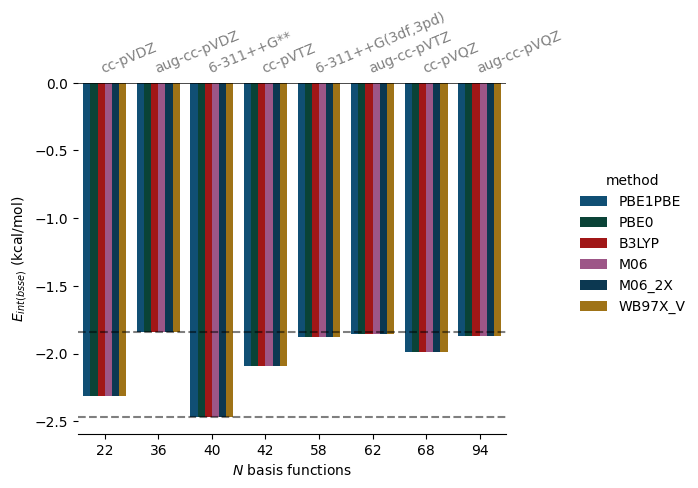

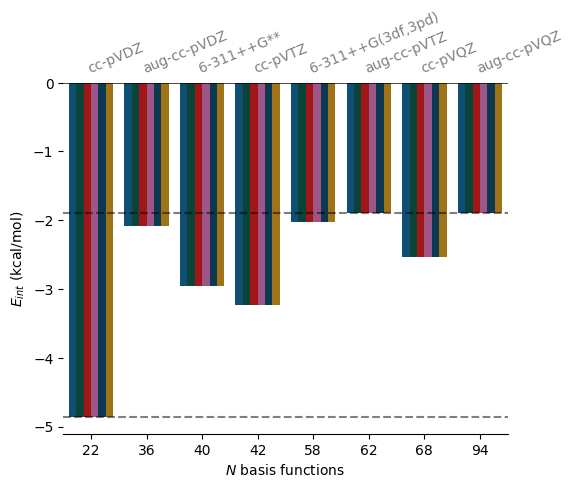

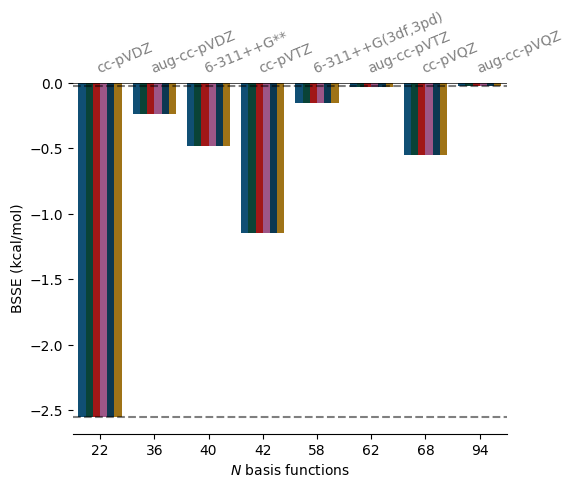

In [543]:
import seaborn as sns
import matplotlib.pyplot as plt


def cat_plot(key):

    def annotate(data, **kws):
        # 
        n = len(data)
        ax = plt.gca()
        nbas = combined_intE["nbas"]
        labels = combined_intE["basis_set"]
        
        pairs = zip(nbas, labels)
        pairs = list(set(pairs))
        pairs.sort(key=lambda x: x[0])
        
        key_a_min = combined_intE[key].min()
        key_a_max = combined_intE[key].max()
        ypos = 0.99 if key_a_min < 0 else 0.01
        va = "top" if key_a_min < 0 else "bottom"

        ax.axhline(key_a_min, color="k", alpha=0.5, linestyle="--")
        ax.axhline(key_a_max, color="k", alpha=0.5, linestyle="--")
        ax.axhline(0, color="k", alpha=1.0, linestyle="-", linewidth=0.5)
        
        for i, _ in enumerate(pairs):
            label = _[1]
            if label == "6-311++G(3df,3pd)aug-cc-pV5Z":
                label = "6-311++G(3df,3pd)"
            ax.text(i/len(pairs) + 1/len(pairs)/2.5, 1.02 , label, 
                    rotation=22.5,
                transform=ax.transAxes,
                    fontsize=10,
                    alpha=0.5,
                    va="bottom",
                    color="k"
               )

    g = sns.catplot(
            data=combined_intE, kind="bar",
            x="nbas", y=key, hue="method",
            # errorbar="sd",
            palette=eric_cmap, alpha=1.0, height=6,
        )
    
    g.fig.set_size_inches(7,5)
    g.despine(left=True)
    g.set_axis_labels("$N$ basis functions", key)
    return g.map_dataframe(annotate)

comb = []

_=["$E_{int (bsse)}$ (kcal/mol)", "$E_{int}$ (kcal/mol)", "BSSE (kcal/mol)"]
g = cat_plot(_[0])
g = cat_plot(_[1])
g._legend.remove()
g = cat_plot(_[2])
g._legend.remove()

In [26]:
#!/usr/bin/env python
# Copyright 2021-2024 The PySCF Developers. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

####################################################
# Example of interaction energy with counterpoise correction
####################################################

import pyscf
from gpu4pyscf.dft import rks

atom_A = [
    ('O', (0.000000, 0.000000, 0.000000)),
    ('H', (0.000000, 0.757160, 0.586260)),
    ('H', (0.260455, 0.000000, -0.872893))
]

atom_B = [
    ('O', (3.000000, 0.500000,  0.000000)),
    ('H', ( 3.758602, 0.500000,  0.504284)),
    ('H', (3.260455, 0.500000, -0.872893))
]

atom_AB = atom_A + atom_B
BASIS='cc-pVTZ'

mol_A = pyscf.M(atom=atom_A, basis=BASIS).build()
mol_B = pyscf.M(atom=atom_B, basis=BASIS).build()
mol_AB = pyscf.M(atom=atom_AB, basis=BASIS).build()

# Monomer A in the dimer basis
mol_A_ghost = mol_A.copy()
ghost_atoms_B = mol_B.atom
mol_A_ghost.atom.extend([('X-' + atom[0], atom[1]) for atom in ghost_atoms_B])
mol_A_ghost.build()

# Monomer B in the dimer basis
mol_B_ghost = mol_B.copy()
ghost_atoms_A = mol_A.atom
mol_B_ghost.atom.extend([('X-' + atom[0], atom[1]) for atom in ghost_atoms_A])
mol_B_ghost.build()

def solve_dft(mol, xc='b3lyp'):
    mf = rks.RKS(mol, xc=xc).density_fit()
    mf.grids.atom_grid = (99,590)
    return mf.kernel()

E_AB = solve_dft(mol_AB)
E_A = solve_dft(mol_A)
E_B = solve_dft(mol_B)
interaction_energy_no_bsse = E_AB - (E_A + E_B)
print(f"Interaction Energy without BSSE Correction: {interaction_energy_no_bsse:.6f} Hartree")

E_A_ghost = solve_dft(mol_A_ghost)
E_B_ghost = solve_dft(mol_B_ghost)
interaction_energy_bsse = E_AB - (E_A_ghost + E_B_ghost)
print(f"Interaction Energy with BSSE Correction: {interaction_energy_bsse:.6f} Hartree")


WARN: len(magmom) != natm. Set magmom to zero


WARN: len(magmom) != natm. Set magmom to zero

converged SCF energy = -152.902235010433
converged SCF energy = -76.4485794499592
converged SCF energy = -76.454567549414
Interaction Energy without BSSE Correction: 0.000912 Hartree

WARN: Even tempered Gaussians are generated as DF auxbasis for  X-H X-O

converged SCF energy = -76.4497706621506

WARN: Even tempered Gaussians are generated as DF auxbasis for  X-H X-O

converged SCF energy = -76.4552547243054
Interaction Energy with BSSE Correction: 0.002790 Hartree


In [21]:
import pyscf
from gpu4pyscf.cc import ccsd_incore
import pyscf
from gpu4pyscf.dft import rks

# atom_A = [
#     ('O', (0.000000, 0.000000, 0.000000)),
#     ('H', (0.000000, 0.757160, 0.586260)),
#     ('H', (0.260455, 0.000000, -0.872893))
# ]

# atom_B = [
#     ('O', (3.000000, 0.500000,  0.000000)),
#     ('H', ( 3.758602, 0.500000,  0.504284)),
#     ('H', (3.260455, 0.500000, -0.872893))
# ]

atom_AB = atom_A + atom_B
BASIS='cc-pVTZ'


mol_AB = pyscf.M(atom=atom_AB, basis=BASIS).build()

mf = mol_AB.RHF().run()
mf.with_df = None
ABe_tot = ccsd_incore.CCSD(mf).kernel()

mol_A = pyscf.M(atom=atom_A, basis=BASIS).build()

mf = mol_A.RHF().run()
mf.with_df = None
Ae_tot = ccsd_incore.CCSD(mf).kernel()

mol_B = pyscf.M(atom=atom_B, basis=BASIS).build()

mf = mol_B.RHF().run()
mf.with_df = None
Be_tot = ccsd_incore.CCSD(mf).kernel()

converged SCF energy = -152.100975984961
E(CCSD) = -152.6590133600591  E_corr = -0.5580373750979156
converged SCF energy = -76.0474245206711
E(CCSD) = -76.32621469533305  E_corr = -0.2787901746619481
converged SCF energy = -76.0557039144649
E(CCSD) = -76.3337160499495  E_corr = -0.2780121354846042


In [22]:
from ase.units import Hartree, kcal, mol

Ha2kcalmol = Hartree/(kcal/mol)

ccsd_intE = ABe_tot[0] - (Ae_tot[0]  + Be_tot[0])

In [29]:
ABe_tot[0], Ae_tot[0], Be_tot[0]

(-0.5580373750979156, -0.2787901746619481, -0.2780121354846042)

In [30]:
ccsd_intE*Ha2kcalmol

-0.775014957849865

In [24]:
-(-152.6590133600592 - (-76.32621469533306 + -76.33371604994942))*Ha2kcalmol

-0.5756679188204925

In [13]:
# mol = pyscf.M(atom=atom, basis='ccpvdz')
import pyscf
from gpu4pyscf.scf import RHF
from gpu4pyscf.mp import dfmp2

mf = RHF(mol_A).density_fit()
e_hf = mf.kernel()

ptobj = dfmp2.DFMP2(mf)
e_corr, t2 = ptobj.kernel()
e_mp2 = e_hf + e_corr

# It prints out MP2 energies, those energies are assessible in the PT object.
print('MP2 correlation energy:', ptobj.emp2)
print('SCS MP2 correlation energy:', ptobj.emp2_scs)
print('Total energy with SCS MP2:', ptobj.e_tot_scs)

print('----- frozen core --------')

# frozen core
ptobj.frozen = [0]
e_corr, t2 = ptobj.kernel()
e_mp2 = e_hf + e_corr

print('MP2 correlation energy:', ptobj.emp2)
print('SCS MP2 correlation energy:', ptobj.emp2_scs)
print('Total energy with SCS MP2:', ptobj.e_tot_scs)

converged SCF energy = -76.0474168453296
E(DFMP2) = -76.3203731051233  E_corr = -0.272956259793625
E(SCS-DFMP2) = -76.3172109623031  E_corr = -0.269794116973499
MP2 correlation energy: -0.2729562597936252
SCS MP2 correlation energy: -0.2697941169734989
Total energy with SCS MP2: -76.31721096230312
----- frozen core --------
E(DFMP2) = -76.3065055589801  E_corr = -0.259088713650487
E(SCS-DFMP2) = -76.303264702998  E_corr = -0.255847857668383
MP2 correlation energy: -0.2590887136504874
SCS MP2 correlation energy: -0.2558478576683827
Total energy with SCS MP2: -76.303264702998


In [14]:
# mol = pyscf.M(atom=atom, basis='ccpvdz')
import pyscf
from gpu4pyscf.scf import RHF
from gpu4pyscf.mp import dfmp2

mf = RHF(mol_B).density_fit()
e_hf = mf.kernel()

ptobj = dfmp2.DFMP2(mf)
e_corr, t2 = ptobj.kernel()
e_mp2 = e_hf + e_corr

# It prints out MP2 energies, those energies are assessible in the PT object.
print('MP2 correlation energy:', ptobj.emp2)
print('SCS MP2 correlation energy:', ptobj.emp2_scs)
print('Total energy with SCS MP2:', ptobj.e_tot_scs)

print('----- frozen core --------')

# frozen core
ptobj.frozen = [0]
e_corr, t2 = ptobj.kernel()
e_mp2 = e_hf + e_corr

print('MP2 correlation energy:', ptobj.emp2)
print('SCS MP2 correlation energy:', ptobj.emp2_scs)
print('Total energy with SCS MP2:', ptobj.e_tot_scs)

converged SCF energy = -76.0556966329007
E(DFMP2) = -76.3276651727988  E_corr = -0.271968539898067
E(SCS-DFMP2) = -76.3246188655096  E_corr = -0.268922232608903
MP2 correlation energy: -0.2719685398980668
SCS MP2 correlation energy: -0.26892223260890286
Total energy with SCS MP2: -76.3246188655096
----- frozen core --------
E(DFMP2) = -76.3137678695781  E_corr = -0.258071236677379
E(SCS-DFMP2) = -76.3106331061318  E_corr = -0.2549364732311
MP2 correlation energy: -0.25807123667737897
SCS MP2 correlation energy: -0.2549364732311001
Total energy with SCS MP2: -76.3106331061318


In [15]:
# mol = pyscf.M(atom=atom, basis='ccpvdz')
import pyscf
from gpu4pyscf.scf import RHF
from gpu4pyscf.mp import dfmp2

mf = RHF(mol_AB).density_fit()
e_hf = mf.kernel()

ptobj = dfmp2.DFMP2(mf)
e_corr, t2 = ptobj.kernel()
e_mp2 = e_hf + e_corr

# It prints out MP2 energies, those energies are assessible in the PT object.
print('MP2 correlation energy:', ptobj.emp2)
print('SCS MP2 correlation energy:', ptobj.emp2_scs)
print('Total energy with SCS MP2:', ptobj.e_tot_scs)

print('----- frozen core --------')

# frozen core
ptobj.frozen = [0]
e_corr, t2 = ptobj.kernel()
e_mp2 = e_hf + e_corr

print('MP2 correlation energy:', ptobj.emp2)
print('SCS MP2 correlation energy:', ptobj.emp2_scs)
print('Total energy with SCS MP2:', ptobj.e_tot_scs)

converged SCF energy = -152.100946372375
E(DFMP2) = -152.647305776369  E_corr = -0.54635940399394
E(SCS-DFMP2) = -152.640877120858  E_corr = -0.539930748482321
MP2 correlation energy: -0.5463594039939403
SCS MP2 correlation energy: -0.5399307484823215
Total energy with SCS MP2: -152.64087712085774
----- frozen core --------
E(DFMP2) = -152.633378131973  E_corr = -0.532431759597907
E(SCS-DFMP2) = -152.626855986119  E_corr = -0.525909613743391
MP2 correlation energy: -0.5324317595979067
SCS MP2 correlation energy: -0.5259096137433905
Total energy with SCS MP2: -152.62685598611878


In [17]:
(-152.62685598611878 - ( -76.3246188655096  + -76.303264702998 ))*Ha2kcalmol

-8.13137882492296

In [18]:
(-152.64087712085774 - ( -76.3106331061318  + -76.31721096230312))*Ha2kcalmol

-8.178363869027391

In [38]:
from pyscf.geomopt.geometric_solver import optimize

mol = mol_AB #pyscf.M(atom=atom, basis='def2-tzvpp')
mf_GPU = rks.RKS(mol, xc='b3lyp').density_fit()
# mf_GPU.disp = 'd3bj'
mf_GPU.grids.level = 3
mf_GPU.conv_tol = 1e-10
mf_GPU.max_cycle = 50

gradients = []
def callback(envs):
    gradients.append(envs['gradients'])

conv_params = {  # They are default settings
        'convergence_energy': 1e-6,  # Eh
        'convergence_grms': 1e-4,    # Eh/Bohr
        'convergence_gmax': 1.5e-4,  # Eh/Bohr
        'convergence_drms': 1.2e-3,  # Angstrom
        'convergence_dmax': 1.8e-3,  # Angstrom
    }


import time
start_time = time.time()
mol_eq = optimize(mf_GPU, maxsteps=20, callback=callback, **conv_params)
print("Optimized coordinate:")
print(mol_eq.atom_coords())
print('Geometry optimization took', time.time() - start_time, 's')

geometric-optimize called with the following command line:
/pchem-data/meuwly/boittier/home/pycharmm_test/.venv/lib/python3.12/site-packages/ipykernel_launcher.py -f /pchem-data/meuwly/boittier/home/.local/share/jupyter/runtime/kernel-a34b8e0a-b53e-4c40-a7f0-1a6ce41c6173.json

                                        ())))))))))))))))/                     
                                    ())))))))))))))))))))))))),                
                                *)))))))))))))))))))))))))))))))))             
                        #,    ()))))))))/                .)))))))))),          
                      #%%%%,  ())))))                        .))))))))*        
                      *%%%%%%,  ))              ..              ,))))))).      
                        *%%%%%%,         ***************/.        .)))))))     
                #%%/      (%%%%%%,    /*********************.       )))))))    
              .%%%%%%#      *%%%%%%,  *******/,     **********,      .))))))   
  


Geometry optimization cycle 1
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   0.000000   0.000000   0.000000    0.000000  0.000000  0.000000
   H   0.000000   0.757160   0.586260    0.000000  0.000000  0.000000
   H   0.260455   0.000000  -0.872893    0.000000  0.000000  0.000000
   O   3.000000   0.500000   0.000000    0.000000  0.000000  0.000000
   H   3.758602   0.500000   0.504284    0.000000  0.000000  0.000000
   H   3.260455   0.500000  -0.872893    0.000000  0.000000  0.000000
converged SCF energy = -152.902234825324
--------------- DFRKS_Scanner gradients ---------------
         x                y                z
0 O     0.0351293941     0.0338693576    -0.0681150142
1 H    -0.0114730623    -0.0072498864     0.0235989022
2 H    -0.0212147356    -0.0254471344     0.0442592862
3 O     0.0649161540    -0.0015629441    -0.0235981032
4 H    -0.0494599671     0.0002722268    -0.0321854600
5 H    -0.0179030541     0.00011787

Step    0 : Gradient = 6.129e-02/8.379e-02 (rms/max) Energy = -152.9022348253
Hessian Eigenvalues: 5.00000e-02 5.00000e-02 5.00000e-02 ... 6.75249e-01 6.75250e-01 6.75250e-01



Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -0.073331  -0.071978   0.046574   -0.073331 -0.071978  0.046574
   H   0.017652   0.747619   0.517304    0.017652 -0.009541 -0.068956
   H   0.238612   0.044296  -0.842357   -0.021843  0.044296  0.030536
   O   3.007373   0.518458   0.001034    0.007373  0.018458  0.001034
   H   3.800750   0.507261   0.535585    0.042148  0.007261  0.031301
   H   3.288623   0.511520  -0.913384    0.028168  0.011520 -0.040491
converged SCF energy = -152.919281016379
--------------- DFRKS_Scanner gradients ---------------
         x                y                z
0 O     0.0134856172     0.0189033992    -0.0074672380
1 H    -0.0060897620    -0.0103945671     0.0007859167
2 H    -0.0061687223    -0.0073953517     0.0061545368
3 O     0.0084218355    -0.0017045457    -0.0022875223
4 H    -0.0046886881     0.0003178380     0.0005863629
5 H    -0.0049597370     0.00027721

Step    1 : Displace = 6.658e-02/1.079e-01 (rms/max) Trust = 1.000e-01 (=) Grad = 1.293e-02/2.439e-02 (rms/max) E (change) = -152.9192810164 (-1.705e-02) Quality = 1.210
Hessian Eigenvalues: 4.75158e-02 5.00000e-02 5.00000e-02 ... 6.64785e-01 6.75250e-01 7.14314e-01



Geometry optimization cycle 3
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -0.132486  -0.107652   0.061415   -0.059155 -0.035674  0.014841
   H   0.036467   0.730961   0.497327    0.018815 -0.016658 -0.019978
   H   0.225491   0.050116  -0.815786   -0.013121  0.005820  0.026571
   O   3.008140   0.542910  -0.013119    0.000767  0.024452 -0.014153
   H   3.802006   0.517836   0.531340    0.001256  0.010575 -0.004246
   H   3.340049   0.522847  -0.916371    0.051425  0.011327 -0.002987
converged SCF energy = -152.920889376317
--------------- DFRKS_Scanner gradients ---------------
         x                y                z
0 O     0.0033120834    -0.0021643334     0.0022702888
1 H    -0.0014578167    -0.0000725814    -0.0040729100
2 H    -0.0014171493     0.0032350600     0.0011733155
3 O    -0.0019680334    -0.0013560369     0.0013117502
4 H     0.0015936500     0.0002155515     0.0001844310
5 H    -0.0000655854     0.00014404

Step    2 : Displace = 4.057e-02/6.786e-02 (rms/max) Trust = 1.414e-01 (+) Grad = 3.271e-03/4.562e-03 (rms/max) E (change) = -152.9208893763 (-1.608e-03) Quality = 1.028
Hessian Eigenvalues: 3.27124e-02 5.00000e-02 5.00000e-02 ... 6.60642e-01 6.75250e-01 7.18723e-01



Geometry optimization cycle 4
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -0.165066  -0.109495   0.062750   -0.032581 -0.001843  0.001335
   H   0.049695   0.715109   0.513225    0.013228 -0.015852  0.015898
   H   0.221549   0.028089  -0.809391   -0.003942 -0.022027  0.006394
   O   3.011164   0.564159  -0.034652    0.003024  0.021249 -0.021533
   H   3.785416   0.526361   0.537821   -0.016590  0.008526  0.006482
   H   3.377002   0.532716  -0.924874    0.036953  0.009868 -0.008503
converged SCF energy = -152.921438667694
--------------- DFRKS_Scanner gradients ---------------
         x                y                z
0 O     0.0010817258    -0.0050395317     0.0030605211
1 H    -0.0008544350     0.0029996967    -0.0013968700
2 H    -0.0001552079     0.0029297156    -0.0022921949
3 O    -0.0027966385    -0.0011247599     0.0013617936
4 H     0.0022952262     0.0002103827     0.0003355653
5 H     0.0004286268     0.00002650

Step    3 : Displace = 2.744e-02/3.955e-02 (rms/max) Trust = 2.000e-01 (+) Grad = 3.632e-03/5.994e-03 (rms/max) E (change) = -152.9214386677 (-5.493e-04) Quality = 1.825
Hessian Eigenvalues: 4.52185e-03 4.99875e-02 5.00000e-02 ... 6.75244e-01 7.11555e-01 8.50868e-01



Geometry optimization cycle 5
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -0.362590  -0.066793   0.066783   -0.197523  0.042702  0.004033
   H   0.153329   0.536079   0.630624    0.103634 -0.179030  0.117399
   H   0.190244  -0.148775  -0.732048   -0.031305 -0.176865  0.077343
   O   3.046073   0.732206  -0.224147    0.034909  0.168047 -0.189496
   H   3.594233   0.602883   0.560263   -0.191183  0.076521  0.022442
   H   3.658876   0.600634  -0.956434    0.281874  0.067918 -0.031560
converged SCF energy = -152.923439032409
--------------- DFRKS_Scanner gradients ---------------
         x                y                z
0 O    -0.0121265774    -0.0059589157     0.0038245893
1 H     0.0048676075     0.0070408025     0.0072316173
2 H     0.0058082607    -0.0012375662    -0.0110944870
3 O    -0.0038720020     0.0011065864    -0.0015636573
4 H     0.0031514380    -0.0003392098     0.0023097762
5 H     0.0021799871    -0.00060942

Step    4 : Displace = 2.191e-01/3.006e-01 (rms/max) Trust = 2.828e-01 (+) Grad = 9.316e-03/1.404e-02 (rms/max) E (change) = -152.9234390324 (-2.000e-03) Quality = 0.977
Hessian Eigenvalues: 4.74421e-03 4.99838e-02 5.00000e-02 ... 6.75382e-01 7.10769e-01 8.98228e-01



Geometry optimization cycle 6
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -0.345634  -0.063613   0.064352    0.016955  0.003181 -0.002431
   H   0.159149   0.541947   0.623472    0.005820  0.005867 -0.007151
   H   0.204084  -0.146074  -0.727638    0.013839  0.002701  0.004411
   O   3.035902   0.725665  -0.217350   -0.010172 -0.006541  0.006797
   H   3.588546   0.594988   0.560562   -0.005687 -0.007895  0.000299
   H   3.637919   0.603289  -0.958324   -0.020957  0.002655 -0.001890
converged SCF energy = -152.923766967134
--------------- DFRKS_Scanner gradients ---------------
         x                y                z
0 O    -0.0049231476    -0.0026739598     0.0020689041
1 H     0.0014593921     0.0031652270     0.0035003760
2 H     0.0020267524    -0.0006249946    -0.0056354560
3 O    -0.0010570413     0.0004251667    -0.0004753909
4 H     0.0014649347     0.0000800283     0.0008085179
5 H     0.0010374758    -0.00036936

Step    5 : Displace = 1.506e-02/2.133e-02 (rms/max) Trust = 3.000e-01 (+) Grad = 4.122e-03/6.021e-03 (rms/max) E (change) = -152.9237669671 (-3.279e-04) Quality = 1.537
Hessian Eigenvalues: 4.93179e-03 3.19449e-02 4.99893e-02 ... 6.39294e-01 6.75875e-01 7.12828e-01



Geometry optimization cycle 7
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -0.322538  -0.048075   0.059325    0.023096  0.015537 -0.005027
   H   0.190354   0.535218   0.621088    0.031205 -0.006728 -0.002385
   H   0.241473  -0.162108  -0.707030    0.037389 -0.016034  0.020607
   O   3.008573   0.730030  -0.225764   -0.027328  0.004365 -0.008413
   H   3.543578   0.582058   0.558168   -0.044968 -0.012930 -0.002394
   H   3.617985   0.618898  -0.960632   -0.019934  0.015610 -0.002308
converged SCF energy = -152.924047475475
--------------- DFRKS_Scanner gradients ---------------
         x                y                z
0 O     0.0033640141     0.0009793629    -0.0007030881
1 H    -0.0020389707    -0.0018459066    -0.0015691203
2 H    -0.0027643972     0.0006504491     0.0022433583
3 O     0.0018564055    -0.0001223459     0.0004900443
4 H    -0.0003561334     0.0005091659    -0.0007773601
5 H    -0.0000560966    -0.00017265

Step    6 : Displace = 3.492e-02/4.896e-02 (rms/max) Trust = 3.000e-01 (=) Grad = 2.605e-03/3.619e-03 (rms/max) E (change) = -152.9240474755 (-2.805e-04) Quality = 1.267
Hessian Eigenvalues: 4.97616e-03 1.53759e-02 4.99891e-02 ... 6.75803e-01 7.12516e-01 9.59250e-01



Geometry optimization cycle 8
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -0.289179  -0.036305   0.054682    0.033359  0.011771 -0.004643
   H   0.221883   0.544835   0.615943    0.031529  0.009617 -0.005145
   H   0.289405  -0.172498  -0.692712    0.047932 -0.010390  0.014318
   O   2.971520   0.725385  -0.225596   -0.037053 -0.004645  0.000168
   H   3.504164   0.559801   0.555424   -0.039413 -0.022257 -0.002744
   H   3.581128   0.634799  -0.962516   -0.036858  0.015901 -0.001883
converged SCF energy = -152.92425265147
--------------- DFRKS_Scanner gradients ---------------
         x                y                z
0 O     0.0065480871     0.0019261302    -0.0018299251
1 H    -0.0031334638    -0.0035685653    -0.0033266380
2 H    -0.0047810934     0.0013971900     0.0051142493
3 O     0.0027548297    -0.0003213390     0.0008046771
4 H    -0.0009413731     0.0007218943    -0.0012761368
5 H    -0.0004429933    -0.000158934

Step    7 : Displace = 4.079e-02/5.112e-02 (rms/max) Trust = 3.000e-01 (=) Grad = 4.939e-03/7.139e-03 (rms/max) E (change) = -152.9242526515 (-2.052e-04) Quality = 1.798
Hessian Eigenvalues: 2.26478e-03 5.14020e-03 4.99911e-02 ... 6.75777e-01 7.12113e-01 1.31136e+00



Geometry optimization cycle 9
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -0.042741   0.036305   0.019694    0.246438  0.072610 -0.034988
   H   0.439147   0.638126   0.569953    0.217264  0.093290 -0.045990
   H   0.623931  -0.232656  -0.590758    0.334526 -0.060158  0.101953
   O   2.705413   0.677139  -0.214206   -0.266107 -0.048246  0.011390
   H   3.245695   0.388322   0.521037   -0.258469 -0.171479 -0.034387
   H   3.304019   0.749109  -0.959976   -0.277108  0.114310  0.002539
converged SCF energy = -152.924398767792
--------------- DFRKS_Scanner gradients ---------------
         x                y                z
0 O     0.0221600313     0.0045185925    -0.0047449586
1 H    -0.0055829697    -0.0103302064    -0.0082854586
2 H    -0.0135295493     0.0059529759     0.0125452429
3 O     0.0025358370    -0.0012903278     0.0019600756
4 H    -0.0034255846     0.0020240959    -0.0028081439
5 H    -0.0021560729    -0.00087754

Step    8 : Displace = 2.911e-01/3.587e-01 (rms/max) Trust = 3.000e-01 (=) Grad = 1.390e-02/2.311e-02 (rms/max) E (change) = -152.9243987678 (-1.461e-04) Quality = 0.185
Hessian Eigenvalues: 5.09978e-03 6.31668e-03 4.99995e-02 ... 6.75764e-01 7.12078e-01 1.31411e+00



Geometry optimization cycle 10
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -0.174579  -0.002168   0.039220   -0.131838 -0.038473  0.019525
   H   0.317166   0.601935   0.593135   -0.121981 -0.036191  0.023182
   H   0.465860  -0.208991  -0.637264   -0.158071  0.023665 -0.046505
   O   2.842220   0.700771  -0.220691    0.136806  0.023632 -0.006485
   H   3.378949   0.459455   0.537502    0.133255  0.071133  0.016465
   H   3.447445   0.705215  -0.966468    0.143425 -0.043894 -0.006491
converged SCF energy = -152.925068398147
--------------- DFRKS_Scanner gradients ---------------
         x                y                z
0 O     0.0069107835     0.0016029006    -0.0019776266
1 H    -0.0020450709    -0.0043995651    -0.0038784817
2 H    -0.0054478186     0.0025120654     0.0056553868
3 O     0.0027851366    -0.0003434374     0.0007139589
4 H    -0.0013144804     0.0010080643    -0.0008597208
5 H    -0.0008905274    -0.0003796

Step    9 : Displace = 1.460e-01/1.673e-01 (rms/max) Trust = 1.455e-01 (-) Grad = 5.381e-03/8.245e-03 (rms/max) E (change) = -152.9250683981 (-6.696e-04) Quality = 0.599
Hessian Eigenvalues: 5.06295e-03 1.11334e-02 4.81094e-02 ... 6.75752e-01 7.12101e-01 1.05909e+00



Geometry optimization cycle 11
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -0.142631   0.000220   0.036327    0.031948  0.002388 -0.002893
   H   0.323621   0.635511   0.580739    0.006456  0.033576 -0.012396
   H   0.520211  -0.212211  -0.620143    0.054351 -0.003220  0.017120
   O   2.809534   0.684143  -0.212900   -0.032686 -0.016628  0.007791
   H   3.360914   0.417302   0.526788   -0.018036 -0.042153 -0.010714
   H   3.405008   0.731260  -0.965325   -0.042437  0.026045  0.001143
converged SCF energy = -152.925348205682
--------------- DFRKS_Scanner gradients ---------------
         x                y                z
0 O     0.0047452787     0.0010228035    -0.0012157090
1 H    -0.0008885260    -0.0031247058    -0.0025199296
2 H    -0.0040171629     0.0019063087     0.0033536574
3 O     0.0017595598    -0.0002088989     0.0005936338
4 H    -0.0008322932     0.0009389728    -0.0004960771
5 H    -0.0007676896    -0.0005338

Step   10 : Displace = 4.389e-02/6.040e-02 (rms/max) Trust = 1.455e-01 (=) Grad = 3.634e-03/5.569e-03 (rms/max) E (change) = -152.9253482057 (-2.798e-04) Quality = 1.824
Hessian Eigenvalues: 2.41601e-03 5.95534e-03 4.20937e-02 ... 6.75740e-01 7.11745e-01 9.15980e-01



Geometry optimization cycle 12
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -0.013572   0.022262   0.016917    0.129058  0.022042 -0.019410
   H   0.343358   0.763153   0.526815    0.019736  0.127642 -0.053924
   H   0.774276  -0.257901  -0.474226    0.254065 -0.045690  0.145918
   O   2.670432   0.633470  -0.224821   -0.139102 -0.050672 -0.011920
   H   3.230867   0.211583   0.435734   -0.130046 -0.205719 -0.091054
   H   3.269323   0.883537  -0.934912   -0.135685  0.152278  0.030412
converged SCF energy = -152.92556716903
--------------- DFRKS_Scanner gradients ---------------
         x                y                z
0 O    -0.0048993650    -0.0009759135    -0.0004253465
1 H     0.0036568281     0.0041979013     0.0036729845
2 H     0.0056518096    -0.0030620387    -0.0039535085
3 O    -0.0052983344     0.0007880079    -0.0002497538
4 H     0.0008097684    -0.0003787811     0.0009908133
5 H     0.0000824119    -0.00056660

Step   11 : Displace = 2.057e-01/3.092e-01 (rms/max) Trust = 2.058e-01 (+) Grad = 5.122e-03/7.546e-03 (rms/max) E (change) = -152.9255671690 (-2.190e-04) Quality = 0.258
Hessian Eigenvalues: 4.94975e-03 9.17851e-03 3.95214e-02 ... 6.75768e-01 7.12019e-01 9.55523e-01



Geometry optimization cycle 13
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -0.088552  -0.003708   0.032032   -0.074980 -0.025970  0.015115
   H   0.267325   0.731928   0.546522   -0.076033 -0.031225  0.019707
   H   0.662751  -0.220084  -0.537468   -0.111526  0.037817 -0.063242
   O   2.758645   0.640397  -0.212682    0.088212  0.006926  0.012139
   H   3.333052   0.279240   0.470533    0.102185  0.067657  0.034800
   H   3.342585   0.828319  -0.953474    0.073262 -0.055218 -0.018562
converged SCF energy = -152.926098586089
--------------- DFRKS_Scanner gradients ---------------
         x                y                z
0 O    -0.0042081820    -0.0018398902     0.0009106736
1 H     0.0022870654     0.0028371784     0.0021183352
2 H     0.0026017188    -0.0011321616    -0.0038508165
3 O    -0.0015940181     0.0005228152     0.0001771175
4 H     0.0009775809     0.0001525066     0.0008530252
5 H    -0.0000622357    -0.0005401

Step   12 : Displace = 1.032e-01/1.349e-01 (rms/max) Trust = 2.058e-01 (=) Grad = 3.353e-03/4.783e-03 (rms/max) E (change) = -152.9260985861 (-5.314e-04) Quality = 0.755
Hessian Eigenvalues: 5.11778e-03 1.43809e-02 2.83363e-02 ... 6.75744e-01 7.11858e-01 8.95853e-01



Geometry optimization cycle 14
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -0.078093  -0.010928   0.031444    0.010459 -0.007220 -0.000588
   H   0.212032   0.763611   0.532394   -0.055293  0.031684 -0.014128
   H   0.714235  -0.209871  -0.490308    0.051484  0.010213  0.047160
   O   2.755648   0.622728  -0.221173   -0.002997 -0.017669 -0.008492
   H   3.332694   0.224857   0.439662   -0.000358 -0.054383 -0.030871
   H   3.339045   0.865652  -0.946468   -0.003541  0.037333  0.007006
converged SCF energy = -152.926460345298
--------------- DFRKS_Scanner gradients ---------------
         x                y                z
0 O    -0.0057504201    -0.0026858278     0.0009560407
1 H     0.0025072429     0.0041066995     0.0026218769
2 H     0.0039350258    -0.0016425031    -0.0044380618
3 O    -0.0020430335     0.0006901136     0.0000785573
4 H     0.0012565649    -0.0001532888     0.0010400562
5 H     0.0000961897    -0.0003136

Step   13 : Displace = 4.971e-02/7.429e-02 (rms/max) Trust = 2.911e-01 (+) Grad = 4.409e-03/6.418e-03 (rms/max) E (change) = -152.9264603453 (-3.618e-04) Quality = 1.956
Hessian Eigenvalues: 3.28167e-04 8.69332e-03 2.15570e-02 ... 6.75972e-01 7.12278e-01 1.01515e+00



Geometry optimization cycle 15
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   0.004215  -0.049129   0.044836    0.082308 -0.038200  0.013392
   H  -0.139267   0.848349   0.383491   -0.351299  0.084738 -0.148902
   H   0.966871  -0.050565  -0.117798    0.252636  0.159306  0.372510
   O   2.759179   0.525304  -0.306029    0.003532 -0.097424 -0.084856
   H   3.331251  -0.065431   0.197624   -0.001443 -0.290288 -0.242038
   H   3.352007   1.047161  -0.855969    0.012963  0.181509  0.090499
converged SCF energy = -152.927112040239
--------------- DFRKS_Scanner gradients ---------------
         x                y                z
0 O    -0.0078030970    -0.0076519440    -0.0030231460
1 H     0.0007597564     0.0079490010     0.0025960762
2 H     0.0100854563    -0.0011060377     0.0015202497
3 O    -0.0054299290     0.0018635986    -0.0027898001
4 H     0.0006527606    -0.0019332983     0.0013090990
5 H     0.0017310882     0.0008802

Step   14 : Displace = 3.098e-01/4.905e-01 (rms/max) Trust = 3.000e-01 (+) Grad = 7.691e-03/1.134e-02 (rms/max) E (change) = -152.9271120402 (-6.517e-04) Quality = 0.289
Hessian Eigenvalues: 1.86633e-03 1.11215e-02 2.56519e-02 ... 6.76242e-01 7.12516e-01 8.98606e-01



Geometry optimization cycle 16
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   0.006391  -0.054219   0.065976    0.002177 -0.005090  0.021140
   H  -0.199659   0.840555   0.372875   -0.060392 -0.007795 -0.010616
   H   0.938162   0.028252  -0.205343   -0.028709  0.078817 -0.087545
   O   2.789980   0.475198  -0.252208    0.030801 -0.050106  0.053821
   H   3.439179  -0.057694   0.220241    0.107929  0.007737  0.022618
   H   3.300642   1.023860  -0.855540   -0.051365 -0.023301  0.000429
converged SCF energy = -152.927994003139
--------------- DFRKS_Scanner gradients ---------------
         x                y                z
0 O    -0.0045089959    -0.0082071401     0.0005606404
1 H     0.0003038312     0.0067708228     0.0012902749
2 H     0.0056570683     0.0017173280    -0.0023428446
3 O    -0.0043523589    -0.0003257560    -0.0003888965
4 H     0.0020555497    -0.0007706973     0.0007955089
5 H     0.0008509167     0.0008159

Step   15 : Displace = 8.160e-02/1.177e-01 (rms/max) Trust = 3.000e-01 (=) Grad = 5.804e-03/9.381e-03 (rms/max) E (change) = -152.9279940031 (-8.820e-04) Quality = 0.952
Hessian Eigenvalues: 1.98632e-03 1.39173e-02 2.31601e-02 ... 6.76013e-01 7.11763e-01 8.21358e-01



Geometry optimization cycle 17
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -0.082613  -0.052856   0.050040   -0.089005  0.001363 -0.015936
   H  -0.205848   0.813400   0.448710   -0.006189 -0.027154  0.075835
   H   0.839459  -0.046677  -0.244858   -0.098702 -0.074929 -0.039515
   O   2.856405   0.537990  -0.274001    0.066424  0.062792 -0.021793
   H   3.447285   0.011822   0.271613    0.008106  0.069516  0.051372
   H   3.420732   0.992307  -0.905320    0.120089 -0.031553 -0.049780
converged SCF energy = -152.927996327885
--------------- DFRKS_Scanner gradients ---------------
         x                y                z
0 O    -0.0020915398     0.0008112477     0.0012390004
1 H    -0.0009105950     0.0007507127     0.0004408062
2 H     0.0016703254    -0.0022719693    -0.0015983675
3 O     0.0018523818     0.0001356256    -0.0005637327
4 H    -0.0004549063     0.0000247741     0.0001371816
5 H    -0.0000665417     0.0005486

Step   16 : Displace = 1.034e-01/1.330e-01 (rms/max) Trust = 3.000e-01 (=) Grad = 1.961e-03/3.241e-03 (rms/max) E (change) = -152.9279963279 (-2.325e-06) Quality = 0.006
Hessian Eigenvalues: 2.98241e-03 1.62776e-02 2.30344e-02 ... 6.75929e-01 7.11351e-01 7.56182e-01



Geometry optimization cycle 18
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -0.046685  -0.056156   0.053118    0.035928 -0.003300  0.003078
   H  -0.246062   0.813670   0.412027   -0.040214  0.000270 -0.036683
   H   0.884810   0.010843  -0.201062    0.045351  0.057521  0.043795
   O   2.842366   0.509088  -0.268941   -0.014039 -0.028902  0.005060
   H   3.457045  -0.027210   0.239932    0.009760 -0.039032 -0.031682
   H   3.383626   1.005826  -0.888808   -0.037105  0.013519  0.016512
converged SCF energy = -152.928280133446
--------------- DFRKS_Scanner gradients ---------------
         x                y                z
0 O    -0.0016021167    -0.0008415207     0.0006558630
1 H     0.0000052889     0.0011177344     0.0001204061
2 H     0.0008526103    -0.0006606174    -0.0007097824
3 O     0.0003991407    -0.0001723212    -0.0005797276
4 H     0.0000756118    -0.0000086330     0.0001810720
5 H     0.0002697267     0.0005673

Step   17 : Displace = 5.277e-02/8.509e-02 (rms/max) Trust = 5.172e-02 (-) Grad = 1.133e-03/1.925e-03 (rms/max) E (change) = -152.9282801334 (-2.838e-04) Quality = 1.243
Hessian Eigenvalues: 3.23035e-03 1.43473e-02 2.29636e-02 ... 6.75904e-01 7.11636e-01 7.31846e-01



Geometry optimization cycle 19
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   0.001595  -0.056233   0.055918    0.048280 -0.000077  0.002801
   H  -0.311394   0.798614   0.363777   -0.065332 -0.015056 -0.048250
   H   0.936128   0.095931  -0.140940    0.051318  0.085088  0.060122
   O   2.832786   0.475104  -0.260789   -0.009579 -0.033984  0.008152
   H   3.474292  -0.073578   0.199092    0.017247 -0.046369 -0.040839
   H   3.341281   1.016188  -0.870886   -0.042346  0.010362  0.017922
converged SCF energy = -152.928385021121
--------------- DFRKS_Scanner gradients ---------------
         x                y                z
0 O     0.0002970837    -0.0008847061     0.0003335793
1 H     0.0003770420     0.0005632500    -0.0002774669
2 H    -0.0004235939     0.0005329411    -0.0000599645
3 O    -0.0005988965    -0.0008436786    -0.0005031001
4 H     0.0002350073     0.0001466385     0.0001126397
5 H     0.0001178800     0.0004837

Step   18 : Displace = 7.055e-02/1.158e-01 (rms/max) Trust = 7.314e-02 (+) Grad = 7.962e-04/1.150e-03 (rms/max) E (change) = -152.9283850211 (-1.049e-04) Quality = 0.756
Hessian Eigenvalues: 4.27336e-03 1.71908e-02 2.28548e-02 ... 6.75943e-01 7.11522e-01 7.32709e-01



Geometry optimization cycle 20
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -0.009480  -0.057179   0.048177   -0.011075 -0.000946 -0.007741
   H  -0.295031   0.797276   0.381658    0.016363 -0.001338  0.017881
   H   0.925568   0.075002  -0.157845   -0.010560 -0.020929 -0.016904
   O   2.834512   0.491053  -0.258534    0.001726  0.015949  0.002255
   H   3.466945  -0.054402   0.217373   -0.007347  0.019177  0.018280
   H   3.352176   1.004349  -0.884676    0.010895 -0.011839 -0.013790
converged SCF energy = -152.92843317376
--------------- DFRKS_Scanner gradients ---------------
         x                y                z
0 O     0.0003708086    -0.0002009144     0.0004061555
1 H     0.0003448916     0.0002053797    -0.0003306345
2 H    -0.0007437903     0.0000315244    -0.0000301584
3 O    -0.0002267342    -0.0006761311    -0.0005880672
4 H     0.0001163510     0.0001785551     0.0000936059
5 H     0.0001405538     0.00046196

Step   19 : Displace = 2.177e-02/3.001e-02 (rms/max) Trust = 1.034e-01 (+) Grad = 6.472e-04/9.243e-04 (rms/max) E (change) = -152.9284331738 (-4.815e-05) Quality = 1.563
Hessian Eigenvalues: 2.91547e-03 1.19262e-02 2.25400e-02 ... 6.76023e-01 7.12083e-01 7.35442e-01


Geometry optimization is not converged in 20 iterations
Optimized coordinate:
[[-0.01791412 -0.10805185  0.09104068]
 [-0.55752834  1.50663238  0.72122942]
 [ 1.74907026  0.14173329 -0.29828295]
 [ 5.3564522   0.92795535 -0.48855833]
 [ 6.5515772  -0.10280447  0.41077515]
 [ 6.33469445  1.89794397 -1.67179543]]
Geometry optimization took 19.06529951095581 s


In [493]:
ase.io.read("opt.xyz")

Atoms(symbols='OH2OH2', pbc=False)

In [34]:
dir(mol_AB)
# mol_AB.atom
assert mol_AB.check_sanity()

In [36]:
import ase
from ase import Atoms
from ase.data import chemical_symbols
from ase.visualize import view

ase_atoms = ase.Atoms( [chemical_symbols.index(_[0]) for _ in mol_AB.atom], positions = [_[1] for _ in mol_AB.atom])

In [37]:
view(ase_atoms, viewer="x3d")

In [39]:
from physnetjax.data.data import prepare_datasets
from physnetjax.training.loss import dipole_calc
from physnetjax.models.model import EF
from physnetjax.training.training import train_model  # from model import dipole_calc
from physnetjax.data.batches import _prepare_batches as prepare_batches #prepare_batches, prepare_datasets


2025-02-22 13:24:20.660736: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740227060.679936  226084 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740227060.686308  226084 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Created `ArrayHandler` with primary_host=0, replica_id=0orbax-checkpoint version: 0.7.0

In [41]:
from physnetjax.analysis.povray_tool import render_povray

In [47]:
render_povray(ase_atoms, "render_povray.pov")

'render_povray.png'

In [500]:
ase.io.write("opt.xyz", ase_atoms)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_svg import FigureCanvasSVG

# Create multiple catplots
fig1, ax1 = plt.subplots()
plot1 = sns.catplot(data=df1, x='x1', y='y1', kind='box', ax=ax1)

fig2, ax2 = plt.subplots()
plot2 = sns.catplot(data=df2, x='x2', y='y2', kind='box', ax=ax2)

# Create a new figure to combine them
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Copy the plots to the new axes
plot1.fig.axes[0].get_children()
for child in plot1.fig.axes[0].get_children():
    child_copy = copy.copy(child)
    ax1.add_artist(child_copy)

for child in plot2.fig.axes[0].get_children():
    child_copy = copy.copy(child)
    ax2.add_artist(child_copy)

# Save as SVG
plt.savefig('combined_plot.svg', format='svg', bbox_inches='tight')

In [219]:
output["formation_thermo"].T

,temperature_K,pressure_Pa,E0_Eh,S_elec_Eh/K,Cv_elec_Eh/K,Cp_elec_Eh/K,E_elec_Eh,H_elec_Eh,S_trans_Eh/K,Cv_trans_Eh/K,...,G_trans_Eh,G_rot_Eh,G_vib_Eh,S_tot_Eh/K,Cv_tot_Eh/K,Cp_tot_Eh/K,E_0K_Eh,E_tot_Eh,H_tot_Eh,G_tot_Eh
0,-298.15,-101325.0,0.254195,0.0,0.0,0.0,0.254195,0.254195,-0.000052,-0.000005,...,0.013102,0.002709,0.012407,-0.000066,-0.00001,-0.000013,0.266553,0.263616,0.262672,0.282412


In [192]:
# pd.DataFrame(mean_thermo)

In [193]:

eh_keys = [_.endswith("_Eh") for _ in delta_keys.index]
delta_keys[eh_keys] #*627.509

,0
E0_Eh,-0.145408
E_elec_Eh,-0.145408
H_elec_Eh,-0.145408
E_trans_Eh,0.000000
H_trans_Eh,0.000000
E_rot_Eh,0.000000
H_rot_Eh,0.000000
ZPE_Eh,0.013896
E_vib_Eh,0.013700
H_vib_Eh,0.013700


In [194]:
pd.DataFrame(thermo_results).T

,0,1,2
temperature_K,298.15,298.15,298.15
pressure_Pa,101325,101325,101325
E0_Eh,-152.223723,-76.305408,-76.165783
S_elec_Eh/K,0.0,0.0,0.0
Cv_elec_Eh/K,0,0,0
Cp_elec_Eh/K,0,0,0
E_elec_Eh,-152.223723,-76.305408,-76.165783
H_elec_Eh,-152.223723,-76.305408,-76.165783
S_trans_Eh/K,0.000058,0.000055,0.000055
Cv_trans_Eh/K,0.000005,0.000005,0.000005


In [21]:
pd.DataFrame(standard_res).T

,mol,calcs,energy,gradient,hessian,harmonic,thermo
results_AB,<pyscf.gto.mole.Mole object at 0x14a6fef45130>,"[CALCS.ENERGY, CALCS.GRADIENT, CALCS.HESSIAN, ...",-152.223723,"[[0.8402308148544844, -0.04824873325887104, 0....","[[3.8870499182982488, 0.07535637869336592, -0....","{'freq_error': 4, 'freq_au': [0.50621393048706...","{'temperature': (298.15, 'K'), 'pressure': (10..."
results_A,<pyscf.gto.mole.Mole object at 0x14a6fef454f0>,"[CALCS.ENERGY, CALCS.GRADIENT, CALCS.HESSIAN, ...",-76.305408,"[[-0.009381171834971891, 1.6314067408400252e-0...","[[0.34985653637205866, -3.833753024037699e-05,...","{'freq_error': 0, 'freq_au': [0.47126378030261...","{'temperature': (298.15, 'K'), 'pressure': (10..."
results_B,<pyscf.gto.mole.Mole object at 0x14a64a3f4d10>,"[CALCS.ENERGY, CALCS.GRADIENT, CALCS.HESSIAN, ...",-76.165783,"[[0.02535436651226708, 0.010654573072760187, 0...","[[0.2279991743490869, 0.1355604176322437, 0.20...","{'freq_error': 1, 'freq_au': [0.14147338533297...","{'temperature': (298.15, 'K'), 'pressure': (10..."
results_A_ghost,<pyscf.gto.mole.Mole object at 0x14a6b306c5c0>,[CALCS.ENERGY],-76.319199,NaN,NaN,NaN,NaN
results_B_ghost,<pyscf.gto.mole.Mole object at 0x14a647f47ef0>,[CALCS.ENERGY],-76.175253,NaN,NaN,NaN,NaN


In [140]:
(-0.015065 	- -0.014083 	 - -0.014083)*627.509

8.220995409

In [121]:

import numpy as np
import pyscf
from pyscf.hessian import thermo
from gpu4pyscf.dft import rks

from enum import Enum as ENUM

class THEORY(ENUM):
    DFT = 0
    HF = 1
    MP2 = 2
    CCSD = 3
    MP3 = 4

class BASIS(ENUM):
    def2_tzvpp = 0
    def2_tzvp = 1


class CALCS(ENUM):
    ENERGY = 0
    GRADIENT = 1
    HESSIAN = 2
    HARMONIC = 3
    THERMO = 4

all_theory = [THEORY.DFT, THEORY.HF, THEORY.MP2, THEORY.CCSD, THEORY.MP3]
all_basis = [BASIS.def2_tzvpp, BASIS.def2_tzvp]
all_calcs = [CALCS.ENERGY, CALCS.GRADIENT, CALCS.HESSIAN, CALCS.HARMONIC, CALCS.THERMO]


def setup_mol(atom, basis, log_file='./pyscf.log', 
              gpu=True,
verbose=6, 
lebedev_grids=(99,590),
scf_tol=1e-10,
scf_max_cycle=50,
cpscf_tol=1e-3,
conv_tol=1e-10,
conv_tol_cpscf=1e-3,
):
    print(atom)
    atom_names = list(set([_.split()[0] for _ in atom.split("\n") if len(_.split()) > 0]))
    
    mol = pyscf.M(
        atom=atom,                         # water molecule
        basis=basis,                # basis set
        output=log_file,              # save log file
        verbose=verbose                          # control the level of print info
        )

    if gpu:
        mf_GPU = rks.RKS(                      # restricted Kohn-Sham DFT
            mol,                               # pyscf.gto.object
            xc='b3lyp'                         # xc funtionals, such as pbe0, wb97m-v, tpss,
            ).density_fit()                    # density fitting
    else:
        mf_GPU = rks.RKS(                      # restricted Kohn-Sham DFT
            mol,                               # pyscf.gto.object
            xc='b3lyp'                         # xc funtionals, such as pbe0, wb97m-v, tpss,
            )                     # density fitting

    mf_GPU.grids.atom_grid = lebedev_grids      # (99,590) lebedev grids, (75,302) is often enough
    mf_GPU.conv_tol = scf_tol                # controls SCF convergence tolerance
    mf_GPU.max_cycle = scf_max_cycle                  # controls max iterations of SCF
    mf_GPU.conv_tol_cpscf = conv_tol_cpscf           # controls max iterations of CPSCF (for hessian)

    return mol, mf_GPU



def compute_dft(mol, calcs, engine):

    output = {"mol": mol, "calcs": calcs}

    if CALCS.ENERGY in calcs:
        # Compute Energy
        e_dft = engine.kernel()
        print(f"total energy = {e_dft}")       # -76.46668196729536
        output['energy'] = e_dft

    if CALCS.GRADIENT in calcs:
        # Compute Gradient
        g = engine.nuc_grad_method()
        g_dft = g.kernel()
        output['gradient'] = g_dft

    if CALCS.HESSIAN in calcs:
        # Compute Hessian
        h = engine.Hessian()
        h.auxbasis_response = 2                # 0: no aux contribution, 1: some contributions, 2: all
        engine.cphf_grids.atom_grid = (50,194) # customize grids for solving CPSCF equation, SG1 by default
        h_dft = h.kernel()
        output['hessian'] = h_dft

    if CALCS.HARMONIC in calcs:
        # harmonic analysis
        results = thermo.harmonic_analysis(mol, h_dft)
        thermo.dump_normal_mode(mol, results)
        output['harmonic'] = results

    if CALCS.THERMO in calcs:
        results = thermo.thermo(
            engine,                            # GPU4PySCF object
            results['freq_au'],
            298.15,                            # room temperature
            101325)                            # standard atmosphere

        thermo.dump_thermo(mol, results)
        output['thermo'] = results

    if CALCS.HESSIAN in calcs:
        # force translational symmetry
        natm = mol.natm
        h_dft = h_dft.transpose([0,2,1,3]).reshape(3*natm,3*natm)
        h_diag = h_dft.sum(axis=0)
        h_dft -= np.diag(h_diag)
        output['hessian'] = h_dft

    return output



supermol = '''
O     -1.000000000     0.000000000     2.500000000
H    -1.663641000    -0.383071000     3.095377000
H     -1.663588000     0.383072000     3.095377000
O     0.000000000     0.000000000     2.500000000
H    -2.663641000    -0.383071000     3.095377000
H     0.663588000     0.383072000     3.095377000
'''

monomer_a = '''
O     -1.000000000     0.000000000     2.500000000
H    -1.663641000    -0.383071000     3.095377000
H     -1.663588000     0.383072000     3.095377000
'''

monomer_b = '''
O     0.000000000     0.000000000     2.500000000
H    -2.663641000    -0.383071000     3.095377000
H     0.663588000     0.383072000     3.095377000
'''

monomer_a_ghost = "\n".join([*["ghost:"+_  for _ in monomer_b.split("\n")[1:-1]], *[""+_  for _ in monomer_b.split("\n")[1:-1]]])
monomer_b_ghost = "\n".join([*[""+_  for _ in monomer_b.split("\n")[1:-1]], *["ghost:"+_  for _ in monomer_b.split("\n")[1:-1]]])

print(monomer_b_ghost)

O     0.000000000     0.000000000     2.500000000
H    -2.663641000    -0.383071000     3.095377000
H     0.663588000     0.383072000     3.095377000
ghost:O     0.000000000     0.000000000     2.500000000
ghost:H    -2.663641000    -0.383071000     3.095377000
ghost:H     0.663588000     0.383072000     3.095377000


In [122]:
[_.split()[0] for _ in monomer_a_ghost.split("\n")]

['ghost:O', 'ghost:H', 'ghost:H', 'O', 'H', 'H']

In [124]:
mol.atom_charges()

array([8, 1, 1, 0, 0, 0], dtype=int32)

In [125]:
dir(mol)

['_TemporaryMoleContext',
 '__add__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_suffix',
 '_atm',
 '_atom',
 '_bas',
 '_basis',
 '_build_symmetry',
 '_built',
 '_ctx_lock',
 '_ecp',
 '_ecpbas',
 '_enuc',
 '_env',
 '_keys',
 '_libcint_ctr_coeff',
 '_nao',
 '_nelectron',
 '_pseudo',
 '_symm_axes',
 '_symm_orig',
 'ao2mo',
 'ao_labels',
 'ao_loc',
 'ao_loc_2c',
 'ao_loc_nr',
 'ao_rotation_matrix',
 'aoslice_2c_by_atom',
 'aoslice_by_atom',
 'aoslice_nr_by_atom',
 'apply',
 'atom',
 'atom_charge',
 'atom_charges',
 'atom_coord',
 'atom_coords',
 'atom_mass_list',
 'atom_nelec_core',
 'atom_nshells',

In [126]:
all_output = {}
all_molecules = { 
    # "supermol": supermol, 
    #              "monomer_a": monomer_a, 
    #              "monomer_b": monomer_b, 
                 "monomer_a_ghost": monomer_a_ghost, 
                 "monomer_b_ghost": monomer_b_ghost}


In [133]:
monomer_b_ghost

m, e = setup_mol(monomer_b_ghost, "6311g", gpu=False)

O     0.000000000     0.000000000     2.500000000
H    -2.663641000    -0.383071000     3.095377000
H     0.663588000     0.383072000     3.095377000
ghost:O     0.000000000     0.000000000     2.500000000
ghost:H    -2.663641000    -0.383071000     3.095377000
ghost:H     0.663588000     0.383072000     3.095377000
overwrite output file: ./pyscf.log


In [134]:
print_basis(m)

total number of shells 26, total number of AO functions 38
(0, 'O', '2p', 'z')
(3, 'GHOST-O', '2p', 'z')
0 O 2pz   
3 GHOST-O 2pz   
shell 0 on atom 0 l = 0 has 1 contracted GTOs
shell 1 on atom 0 l = 0 has 1 contracted GTOs
shell 2 on atom 0 l = 0 has 1 contracted GTOs
shell 3 on atom 0 l = 0 has 1 contracted GTOs
shell 4 on atom 0 l = 1 has 1 contracted GTOs
shell 5 on atom 0 l = 1 has 1 contracted GTOs
shell 6 on atom 0 l = 1 has 1 contracted GTOs
shell 7 on atom 1 l = 0 has 1 contracted GTOs
shell 8 on atom 1 l = 0 has 1 contracted GTOs
shell 9 on atom 1 l = 0 has 1 contracted GTOs
shell 10 on atom 2 l = 0 has 1 contracted GTOs
shell 11 on atom 2 l = 0 has 1 contracted GTOs
shell 12 on atom 2 l = 0 has 1 contracted GTOs
shell 13 on atom 3 l = 0 has 1 contracted GTOs
shell 14 on atom 3 l = 0 has 1 contracted GTOs
shell 15 on atom 3 l = 0 has 1 contracted GTOs
shell 16 on atom 3 l = 0 has 1 contracted GTOs
shell 17 on atom 3 l = 1 has 1 contracted GTOs
shell 18 on atom 3 l = 1 has 1 

In [135]:
e.kernel()

WARN: Singularity detected in overlap matrix (condition number = 1.13e+18). SCF may be inaccurate and hard to converge.
/pchem-data/meuwly/boittier/home/pycharmm_test/.venv/lib/python3.12/site-packages/pyscf/lib/linalg_helper.py:1407: LinAlgWarning: Ill-conditioned matrix (rcond=1.08129e-20): result may not be accurate.
  return scipy.linalg.solve(a, b)
WARN: SCF failed to converge


nan

In [107]:
all_calcs
ghost_cals = [CALCS.ENERGY, CALCS.GRADIENT]

In [111]:
for k, m in all_molecules.items():
    print(k, m)
    calcs = all_calcs
    if "ghost" in k:
        print("GHOST ATOM CALC")
        calcs = ghost_cals
        mol, mf_GPU = setup_mol(m, "631g", gpu=False)
    else:
        mol, mf_GPU = setup_mol(m, "631g", gpu=False)
        
    print(calcs)

    print_basis(mol)

    all_output[k] = compute_dft(mol, calcs, mf_GPU)

monomer_a_ghost ghost:O     0.000000000     0.000000000     2.500000000
ghost:H    -2.663641000    -0.383071000     3.095377000
ghost:H     0.663588000     0.383072000     3.095377000
O     0.000000000     0.000000000     2.500000000
H    -2.663641000    -0.383071000     3.095377000
H     0.663588000     0.383072000     3.095377000
GHOST ATOM CALC
ghost:O     0.000000000     0.000000000     2.500000000
ghost:H    -2.663641000    -0.383071000     3.095377000
ghost:H     0.663588000     0.383072000     3.095377000
O     0.000000000     0.000000000     2.500000000
H    -2.663641000    -0.383071000     3.095377000
H     0.663588000     0.383072000     3.095377000
overwrite output file: ./pyscf.log


AttributeError: module 'pyscf.gto' has no attribute 'RKS'

In [94]:
all_output

{}

In [136]:
import pyscf
from gpu4pyscf.dft import rks

atom_A = [
    ('O', (0.000000, 0.000000, 0.000000)),
    ('H', (0.000000, 0.757160, 0.586260)),
    ('H', (0.000000, -0.757160, 0.586260))
]

atom_B = [
    ('O', (0.000000, 0.000000, 2.913530)),
    ('H', (0.000000, 0.757160, 3.499790)),
    ('H', (0.000000, -0.757160, 3.499790))
]

atom_AB = atom_A + atom_B

mol_A = pyscf.M(atom=atom_A, basis='cc-pVDZ').build()
mol_B = pyscf.M(atom=atom_B, basis='cc-pVDZ').build()
mol_AB = pyscf.M(atom=atom_AB, basis='cc-pVDZ').build()

# Monomer A in the dimer basis
mol_A_ghost = mol_A.copy()
ghost_atoms_B = mol_B.atom
mol_A_ghost.atom.extend([('X-' + atom[0], atom[1]) for atom in ghost_atoms_B])
mol_A_ghost.build()

# Monomer B in the dimer basis
mol_B_ghost = mol_B.copy()
ghost_atoms_A = mol_A.atom
mol_B_ghost.atom.extend([('X-' + atom[0], atom[1]) for atom in ghost_atoms_A])
mol_B_ghost.build()

def solve_dft(mol, xc='b3lyp'):
    mf = rks.RKS(mol, xc=xc).density_fit()
    mf.grids.atom_grid = (99,590)
    return mf.kernel()

E_AB = solve_dft(mol_AB)
E_A = solve_dft(mol_A)
E_B = solve_dft(mol_B)
interaction_energy_no_bsse = E_AB - (E_A + E_B)
print(f"Interaction Energy without BSSE Correction: {interaction_energy_no_bsse:.6f} Hartree")

E_A_ghost = solve_dft(mol_A_ghost)
E_B_ghost = solve_dft(mol_B_ghost)
interaction_energy_bsse = E_AB - (E_A_ghost + E_B_ghost)
print(f"Interaction Energy with BSSE Correction: {interaction_energy_bsse:.6f} Hartree")


WARN: len(magmom) != natm. Set magmom to zero


WARN: len(magmom) != natm. Set magmom to zero

converged SCF energy = -152.847787660763
converged SCF energy = -76.4203784872763
converged SCF energy = -76.4203784872764
Interaction Energy without BSSE Correction: -0.007031 Hartree

WARN: Even tempered Gaussians are generated as DF auxbasis for  X-H X-O

converged SCF energy = -76.42206639478

WARN: Even tempered Gaussians are generated as DF auxbasis for  X-H X-O

converged SCF energy = -76.4233394283902
Interaction Energy with BSSE Correction: -0.002382 Hartree
